## Q1

<b>Data Analysis.<br>
<b>Concerns about the data.<br>
<b>Suggestions on other useful data to collect.

In [1]:
# Import libraries for processing
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import mean
from numpy import std

from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from collections import defaultdict

from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, randint

# Import libraries for modelling
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import os, time, sys
warnings.filterwarnings("ignore")

In [2]:
#Functions & Utils

def dataframe_selector(df, column_list):
    return pd.DataFrame(df, columns=column_list)

def data_to_numeric(df):
    return df.apply(pd.to_numeric)

def rescale_data(df):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled, columns = df.columns)
    return df_scaled

def one_hot_encode(df):
    df_1_hot = pd.get_dummies(df, columns = df.columns.tolist())
    return df_1_hot

def extract_or_remove_by_column(df, val, col_name, choice):
    if choice == 'remove' and val == 'NA':
        df= df[df[col_name].isnull() == False]
        return df
    elif choice == 'remove':
        df= df[df[col_name] != val]
        return df
    elif choice == 'extract' and val == 'NA':
        df= df[df[col_name].isnull()]
        return df
    elif choice == 'extract':
        df= df[df[col_name] == val]
        return df
        
def value_count(df, value):
    val_count = {}
    if value == 'NA':
        for col in df.columns:
            col_value = 0
            for val in df[col].isnull():
                if val == True:
                    col_value += 1
            val_count[col] = [col_value, '{:0.2f}%'.format((float(col_value)/len(df))*100)]
        return val_count
    else:
        for col in df.columns:
            col_value = 0
            for val in df[col] == value:
                if val == True:
                    col_value += 1
            val_count[col] = [col_value, '{:0.2f}%'.format((float(col_value)/len(df))*100)]
        return val_count
    
def fill_col_with_median(df):
    for col in df.columns:
        df[col] = df[col].fillna(df[col].median())
    return df

def remove_outliers(df):
    for col in df.columns:
        df[col] = replace_outlier(df[col])
    return df

def mad_based_outlier(points, thresh=5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    (min_val, max_val) = np.percentile(data, [diff, 100 - diff])
    return ((data < min_val) | (data > max_val))

def std_div(data, threshold=6):
    std = data.std()
    mean = data.mean()
    is_outlier = []
    for val in data:
        if val/std > threshold:
            is_outlier.append(True)
        else:
            is_outlier.append(False)
    return is_outlier

def outlier_vote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(data.index, x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plot_outlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote])):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile based outliers', **kwargs)
    axes[1].set_title('MAD based outliers', **kwargs)
    axes[2].set_title('STD based outliers', **kwargs)
    axes[3].set_title('Majority vote based outliers', **kwargs)
    fig.suptitle('Comparing outlier tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plot_outlier_free(x):
    fig, axes = plt.subplots(nrows=4)
    n_outliers = []
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote])):
        tf_outlier = list(zip(x, func(x)))
        n_outliers.append(len([index for (index, bol) in tf_outlier if bol == True]))
        outlier_free = [index for (index, bol) in tf_outlier if bol == True]
        sns.distplot(outlier_free, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile based outliers, removed: {r}'.format(r=n_outliers[0]), **kwargs)
    axes[1].set_title('MAD-based outliers, removed: {r}'.format(r=n_outliers[1]), **kwargs)
    axes[2].set_title('STD-based outliers, removed: {r}'.format(r=n_outliers[2]), **kwargs)
    axes[3].set_title('Majority vote based outliers, removed: {r}'.format(r=n_outliers[3]), **kwargs)
    fig.suptitle('Outlier removed by method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlier_ratio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlier_vote]
    outlier_dict = {}
    for func in functions:
        func_result = func(data)
        count = 0
        for val in func_result:
            if val == True:
                count += 1 
        outlier_dict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlier_dict

def replace_outlier(data, method = outlier_vote, replace='median'):
    '''replace: median (auto)
    'min_upper' which is the upper bound of the outlier detection'''
    vote = outlier_vote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['place_holder', 'outlier'])
    if replace == 'median':
        replace = x['place_holder'].median()
    elif replace == 'min_upper':
        replace = min([val for (val, vote) in list(zip(data, vote)) if vote == True])
        if replace < data.mean():
            print('There are outliers lower than the sample mean')
            return 'There are outliers lower than the sample mean'
    place_holder_new = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            place_holder_new.append(replace)
        else:
            place_holder_new.append(x.iloc[i][0])
    return place_holder_new

def all_outliers(data):
    outliers_dict = defaultdict(dict)
    for col in data.columns:
        outliers_dict[col] = outlier_ratio(data[col])
    return outliers_dict

### Take a look at the dataset and get summary statistics

In [3]:
# Load data
stores = pd.read_csv('train.csv')
stores_test = pd.read_csv('test.csv')

In [4]:
# Take a look at the first few rows
stores.head()

location_id  crime_rate  proportion_flats  proportion_nonretail new_store  \
0          464   17.600541               0.0                 18.10        no   
1          504    0.603556              20.0                  3.97        no   
2          295    0.606810               0.0                  6.20        no   
3          187    0.012385              55.0                  2.25        no   
4          193    0.016182             100.0                  1.32        no   

   commercial_property  household_size  proportion_newbuilds  \
0                  NaN           2.926                  29.0   
1                14.85           4.520                  10.6   
2                 7.70           2.981                  31.9   
3                 1.95           3.453                  68.1   
4                 3.05           3.816                  59.5   

   public_transport_dist     transport_availability  property_value  \
0                 2.9084      All transport options             666   
1                 2.1398  Average transport options             264   
2                 3.6715     Many transport options             307   
3                 7.3073       No transport options             300   
4                 8.3248  Average transport options             256   

   school_proximity  competitor_density  household_affluency  \
0              20.2              368.74               4.5325   
1              13.0              388.37               1.8150   
2              17.4              378.35               2.9125   
3              15.3              394.72               2.0575   
4              15.1              392.90               0.9875   

   normalised_sales county  
0         -0.399933   c_40  
1          2.216308   c_80  
2          0.166920   c_53  
3         -0.083804   c_65  
4          0.962693   c_97

Data dict as given<br>

location_id: id of Tesco property location<br>
normalised_sales: normalised sales value of Tesco store<br>
crime_rate: crime rate in the area<br>
household_size: mean household size in the area<br>
household_affluency: mean household affluency in the area<br>
public_transport_dist: index of public transport availability in the area<br>
proportion_newbuilds: proportion of newly built property in the area<br>
property_value: average property value in the area<br>
commercial_property: percentage of commercial properties in the area<br>
school_proximity: average school proximity in the area<br>
transport_proximity: proximity of different transport modes<br>
new_store: new Tesco store opened recently<br>
proportion_nonretail: proportion of non-retail commercial properties in the area<br>
competitor_density: density of competitor retailers<br>
proportion_flats: proportion of blocks of flats in the area<br>
county: county code of the area

In [5]:
# Check data types
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location_id             320 non-null    int64  
 1   crime_rate              320 non-null    float64
 2   proportion_flats        320 non-null    float64
 3   proportion_nonretail    320 non-null    float64
 4   new_store               320 non-null    object 
 5   commercial_property     291 non-null    float64
 6   household_size          320 non-null    float64
 7   proportion_newbuilds    320 non-null    float64
 8   public_transport_dist   320 non-null    float64
 9   transport_availability  320 non-null    object 
 10  property_value          320 non-null    int64  
 11  school_proximity        257 non-null    float64
 12  competitor_density      320 non-null    float64
 13  household_affluency     320 non-null    float64
 14  normalised_sales        320 non-null    fl

-  <b>The features new_store, transport_availability and county may need to be changed to category for modelling later

In [6]:
# Numerical and Categorical features
numerical = ['crime_rate', 'proportion_flats', 'proportion_nonretail', 'commercial_property', 'household_size', 
             'proportion_newbuilds', 'public_transport_dist', 'property_value', 'school_proximity', 'competitor_density', 
             'household_affluency']

categorical = ['new_store','transport_availability', 'county']

target = ['normalised_sales']
all_num = numerical + target
all_cat = categorical + target

In [7]:
# Data types look ok, check summary stats
stores.describe()

location_id  crime_rate  proportion_flats  proportion_nonretail  \
count   320.000000  320.000000        320.000000            320.000000   
mean    252.387500    3.596375         10.673438             11.307906   
std     145.600582    7.176342         22.579232              7.032693   
min       1.000000    0.007142          0.000000              0.740000   
25%     126.500000    0.087937          0.000000              5.130000   
50%     251.500000    0.289681          0.000000              9.900000   
75%     377.250000    4.063553         12.500000             18.100000   
max     506.000000   51.693093        100.000000             27.740000   

       commercial_property  household_size  proportion_newbuilds  \
count           291.000000      320.000000            320.000000   
mean             16.868557        3.252803             31.849063   
std              73.806051        0.695442             27.845777   
min               1.750000        0.561000              0.000000   
25%               5.450000        2.879750              6.350000   
50%               9.400000        3.197500             23.400000   
75%              14.050000        3.597250             54.450000   
max            1009.000000        5.725000             94.000000   

       public_transport_dist  property_value  school_proximity  \
count             320.000000      320.000000        257.000000   
mean                3.718765      408.834375         18.589494   
std                 1.984765      170.888974          2.075529   
min                 1.137000      188.000000         13.000000   
25%                 2.138075      277.000000         17.400000   
50%                 3.095750      330.000000         19.100000   
75%                 5.116700      666.000000         20.200000   
max                10.710300      711.000000         21.200000   

       competitor_density  household_affluency  normalised_sales  
count          320.000000           320.000000        320.000000  
mean           359.657562             3.144008         -0.016967  
std             86.048632             1.774041          0.978561  
min              3.500000             0.432500         -1.936974  
25%            376.722500             1.803750         -0.585250  
50%            392.205000             2.808750         -0.143759  
75%            396.352500             4.091875          0.243227  
max            396.900000             9.492500          2.968477

-  <b>From the summary statistics above, we can see that commercial_property, described as a percentage, has atleast 1 entry geater than 100% (1009%)

In [8]:
# Find the rows where percentage is greater than 100
stores.loc[stores['commercial_property'] > 100].head()

location_id  crime_rate  proportion_flats  proportion_nonretail  \
96            90    0.138640               0.0                  6.91   
103          394    0.102864               0.0                  2.46   
224          283   10.541872               0.0                 18.10   

    new_store  commercial_property  household_size  proportion_newbuilds  \
96         no               1009.0           3.069                  60.0   
103        no                123.0           4.155                   7.8   
224        no                767.0           3.185                   1.3   

     public_transport_dist transport_availability  property_value  \
96                  5.7209   No transport options             233   
103                 2.7006   No transport options             193   
224                 2.2616  All transport options             666   

     school_proximity  competitor_density  household_affluency  \
96               17.9              389.39               2.3875   
103               NaN              394.12               1.2050   
224              20.2              396.90               4.5325   

     normalised_sales county  
96          -0.171012   c_48  
103          1.649456   c_68  
224         -0.944983   c_45

In [9]:
# Plot commercial_property
fig = px.box(stores, y="commercial_property", points='all')
fig.show()

<b>Given the constraint in Q2 to use Random Forest, I've decided to not remove these rows but to remove the specific entries as the other features in the record seem reasonable and are potentially useful.

In [10]:
# remove commercial_property > 100%
to_delete = [96, 103, 224]
for num in to_delete:
    stores.at[num, 'commercial_property'] = np.nan


In [11]:
# Find the rows where percentage is greater than 100
stores.loc[stores['commercial_property'] > 100].head()

Empty DataFrame
Columns: [location_id, crime_rate, proportion_flats, proportion_nonretail, new_store, commercial_property, household_size, proportion_newbuilds, public_transport_dist, transport_availability, property_value, school_proximity, competitor_density, household_affluency, normalised_sales, county]
Index: []

### Get a sense of missing values in the dataset

In [12]:
value_count(stores, 'NA')

{'location_id': [0, '0.00%'],
 'crime_rate': [0, '0.00%'],
 'proportion_flats': [0, '0.00%'],
 'proportion_nonretail': [0, '0.00%'],
 'new_store': [0, '0.00%'],
 'commercial_property': [32, '10.00%'],
 'household_size': [0, '0.00%'],
 'proportion_newbuilds': [0, '0.00%'],
 'public_transport_dist': [0, '0.00%'],
 'transport_availability': [0, '0.00%'],
 'property_value': [0, '0.00%'],
 'school_proximity': [63, '19.69%'],
 'competitor_density': [0, '0.00%'],
 'household_affluency': [0, '0.00%'],
 'normalised_sales': [0, '0.00%'],
 'county': [0, '0.00%']}

#### Options to handle records with missing data.
Consider whether the data is missing at random or missing for a systematic reason, then
-  Remove all rows (or columns) with any missing data
-  Try to impute the missing value, this may involve judgment calls (e.g. use column mean, median, or mode)
-  Develop another model to predict the missing values.

Given the constraint to use Random Forests for modelling, we do not need to remove potentially useful data from the model and Random Forests can make reasonable decisions with missing data without guessing about what the missing value might be.

Missing values are interpreted as containing information (i.e., missing for a reason), rather than missing at random. During tree building, split decisions for every node are found by minimizing the loss function and treating missing values as a separate category that can go either left or right.

### Distribution of the target variable normalised_sales

In [13]:
fig = px.box(stores, y="normalised_sales", points='all')
fig.show()

In [14]:
hist_data = [stores['normalised_sales']]
group_labels = ['normalised_sales']
fig = ff.create_distplot(hist_data, group_labels)
fig.show()
print('min: {} max: {} mean: {} std: {}'.format(min(stores['normalised_sales']), max(stores['normalised_sales']), stores['normalised_sales'].mean(), stores['normalised_sales'].std()))

min: -1.9369739683900924 max: 2.9684772596520763 mean: -0.01696673148097644 std: 0.9785613571833174


-  Normally distributed with most values between -1 and 1

### Get a sense of the outliers in the dataset

I will use 3 methods with thresholds (mean absolute deviation: threshold - 3.5, percentile: threshold - 95, standard deviation: threshold - 3) to vote for values that will be classed as outliers.<br>

My thinking is that Random Forests use trees, which split the data into groups (repeatedly) according to whether a case is above or below a selected threshold value on a selected feature variable.  It doesn’t matter how much higher it is, for instance, just if it’s higher. Thus, input outliers don’t have extra influence, like they do in regression, for instance, where they can become known as leverage points. Also, output outliers will affect the estimate of the leaf node they are in, but not the values of any other leaf node.  Again, this is different from other methods – ones John Elder calls “consensus” methods, like regression or neural networks – where every data point affects the estimate at every other data point. Instead, tree methods are “contributory” methods, where only local points – those in the same leaf node – affect a given point’s estimate.  So output outliers have a “quarantined” effect. Thus, outliers that would wildly distort the accuracy of some algorithms have less of an effect on the prediction of a Random Forest.

In [15]:
#create palette
my_palette = ["#1E90FF", "#FFD700", "#00EEEE", "#668B8B", "#EAEAEA", "#FF3030"]
sns.set_palette(my_palette)

<b>Crime Rate feature

In [16]:
outlier_ratio(stores['crime_rate'])

{'percentile_based_outlier': [4, '1.25%'],
 'mad_based_outlier': [97, '30.31%'],
 'std_div': [2, '0.62%'],
 'outlier_vote': [2, '0.62%']}

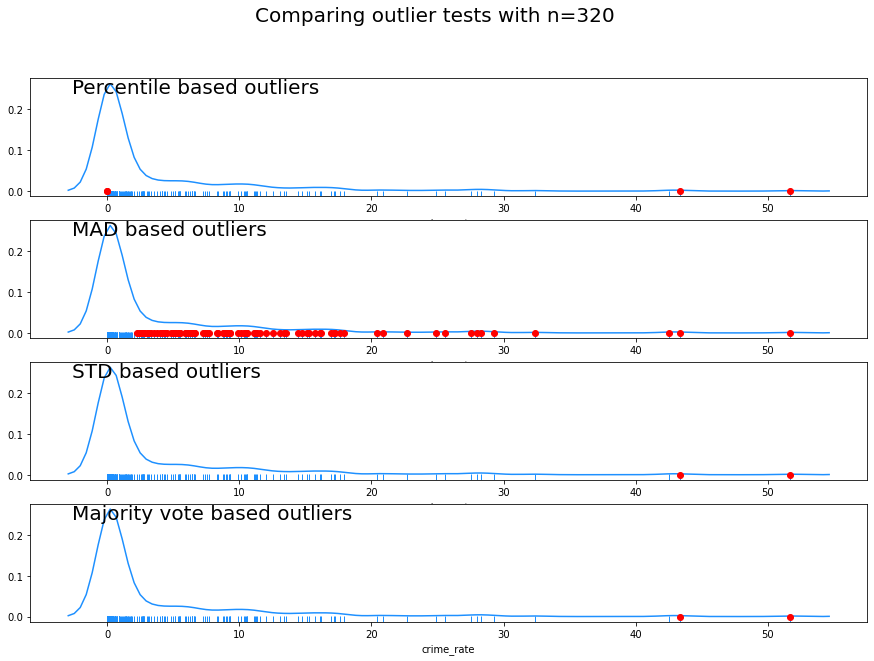

In [17]:
plot_outlier(stores['crime_rate'].sample(320))

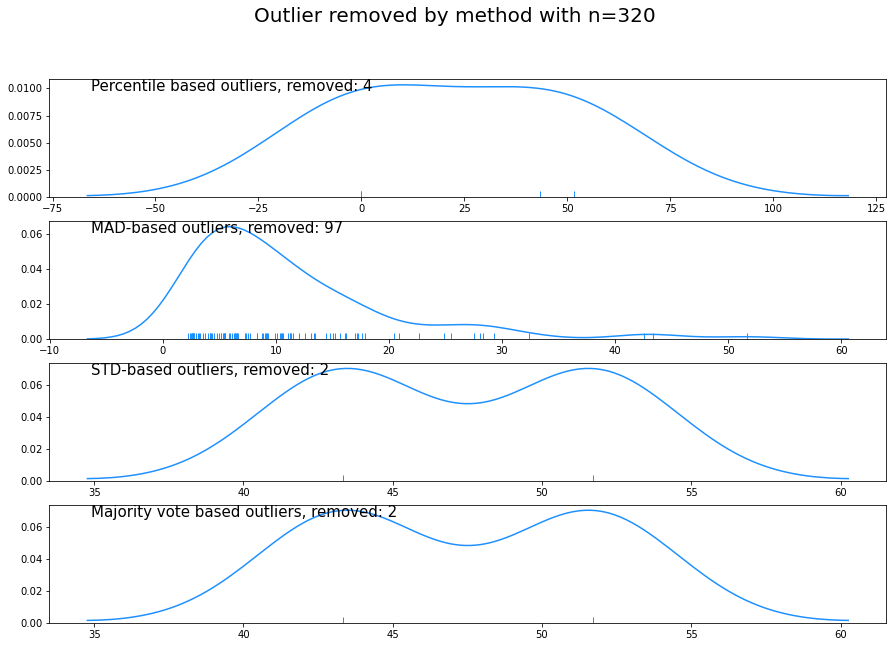

In [18]:
plot_outlier_free(stores['crime_rate'].sample(320))

In [19]:
new_crime_rate = replace_outlier(stores['crime_rate'], replace='min_upper')

In [20]:
stores['crime_rate'] = new_crime_rate
stores['crime_rate'].describe()

count    320.000000
mean       3.570263
std        7.014161
min        0.007142
25%        0.087937
50%        0.289681
75%        4.063553
max       43.337534
Name: crime_rate, dtype: float64

Show only outlier ratio summaries for the rest of the features

<b>Proportion Flats feature

In [21]:
outlier_ratio(stores['proportion_flats'])

{'percentile_based_outlier': [1, '0.31%'],
 'mad_based_outlier': [82, '25.62%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [1, '0.31%']}

In [22]:
new_proportion_flats = replace_outlier(stores['proportion_flats'], replace='min_upper')
stores['proportion_flats'] = new_proportion_flats
#stores['proportion_flats'].describe()

<b>Proportion Nonretail feature

In [23]:
outlier_ratio(stores['proportion_nonretail'])

{'percentile_based_outlier': [6, '1.88%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [0, '0.00%']}

<b>Commercial Property feature

In [24]:
outlier_ratio(stores['commercial_property'])

{'percentile_based_outlier': [0, '0.00%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [0, '0.00%']}

<b>Household Size feature

In [25]:
outlier_ratio(stores['household_size'])

{'percentile_based_outlier': [4, '1.25%'],
 'mad_based_outlier': [2, '0.62%'],
 'std_div': [27, '8.44%'],
 'outlier_vote': [3, '0.94%']}

In [26]:
new_household_size = replace_outlier(stores['household_size'], replace='median')
stores['household_size'] = new_household_size
#stores['household_size'].describe()

<b>Proportion Newbuilds feature

In [27]:
outlier_ratio(stores['proportion_newbuilds'])

{'percentile_based_outlier': [2, '0.62%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [0, '0.00%']}

<b>Public Transport Dist feature

In [28]:
outlier_ratio(stores['public_transport_dist'])

{'percentile_based_outlier': [4, '1.25%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [0, '0.00%']}

<b>Property Value feature

In [29]:
outlier_ratio(stores['property_value'])

{'percentile_based_outlier': [0, '0.00%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [0, '0.00%']}

<b>School Proximity feature

In [30]:
outlier_ratio(stores['school_proximity'])

{'percentile_based_outlier': [0, '0.00%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [257, '80.31%'],
 'outlier_vote': [0, '0.00%']}

<b>Competitor Density feature

In [31]:
outlier_ratio(stores['competitor_density'])

{'percentile_based_outlier': [2, '0.62%'],
 'mad_based_outlier': [56, '17.50%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [2, '0.62%']}

In [32]:
new_competitor_density = replace_outlier(stores['competitor_density'], replace='median')
stores['competitor_density'] = new_competitor_density
#stores['competitor_density'].describe()

<b>Household Affluency feature

In [33]:
outlier_ratio(stores['household_affluency'])

{'percentile_based_outlier': [4, '1.25%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [0, '0.00%']}

### Visualisation

In [34]:
#create palette
my_palette = ["#1E90FF", "#FFD700", "#00EEEE", "#668B8B", "#EAEAEA", "#FF3030"]
sns.set_palette(my_palette)

#### Plot categorical features

In [35]:
for cat in categorical:
    fig = px.histogram(stores, x=cat)
    fig.show()

#### Look at categorical features alongside normalised sales

In [36]:
fig = px.box(stores, y="normalised_sales", x="new_store", points='all')
fig.show()

In [37]:
fig = px.box(stores, y="normalised_sales", x="transport_availability", points='all')
fig.show()

In [38]:
fig = px.scatter(stores, x="transport_availability", y="normalised_sales", color="new_store",hover_name="county")
fig.show()

#### Questions
Are there counties where normalised_sales for <b>ALL</b> store locations are positive?<br>
Are there counties to avoid?

In [39]:
# Take a look at counties with more than 4 stores
county_extract = stores['county'].value_counts().reset_index(name="count").query("count > 4")
#county_extract
high_counties = stores[stores['county'].isin(county_extract['index'])]
#high_counties
fig = px.box(high_counties, y="normalised_sales", x="county", points='all')
fig.show()

#### Observations for categorical features
-  New stores seem to have better sales
-  Locations with many transport options seem to have better sales
-  Some counties have all stores in the county (at least 5 stores) entirely positive sales (c_68, c_83, c_94)
-  Some counties have all stores in the county (at least 5 stores) entirely negative sales (c_39, c_59)

### Correlations

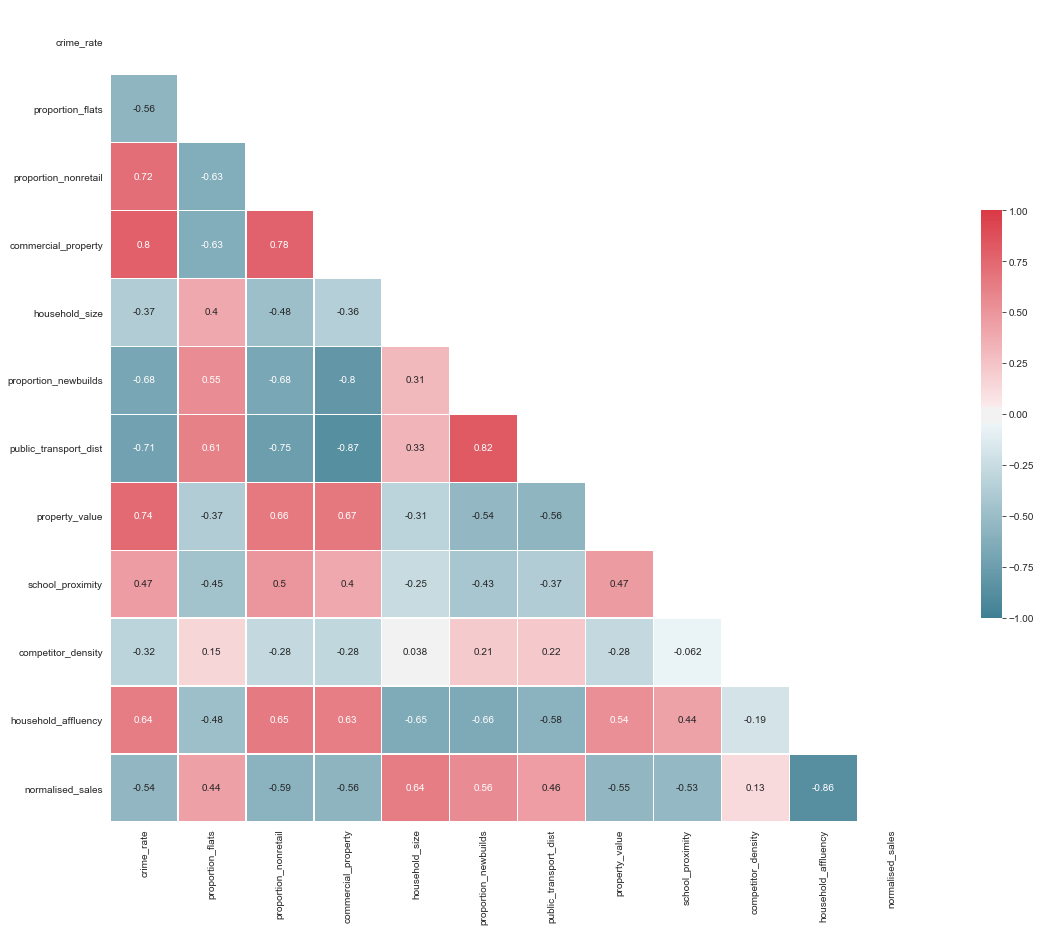

In [40]:
s = stores[all_num]
#whitegrid
sns.set_style('whitegrid')

#compute correlation matrix
corr_matrix=s.corr(method='spearman')

#show with a heatmap
plt.figure(figsize=(20,15))
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Examine relationship between normalised_sales and a few other variables
-  household_affluency (-0.86)
-  household_size (0.64)
-  proportion_nonretail (-0.59)
-  proportion_newbuilds (0.56)

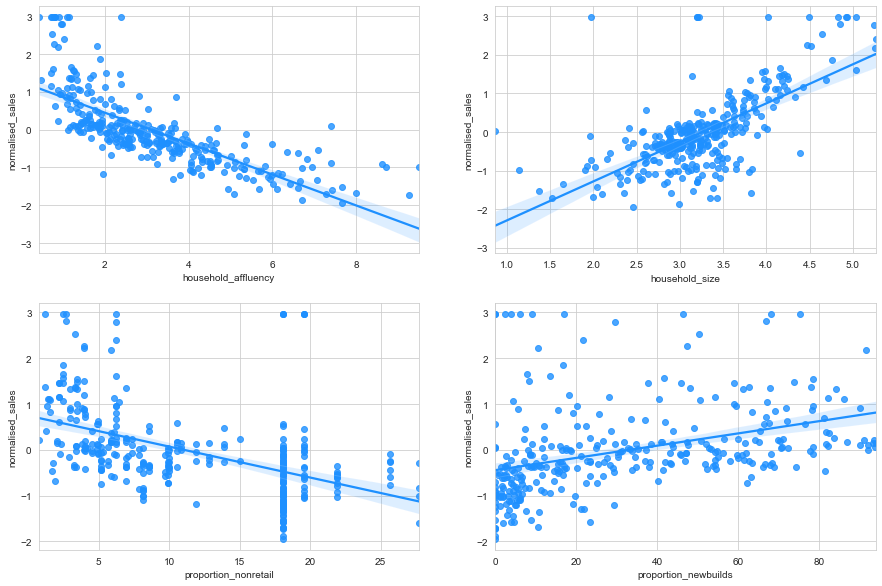

In [41]:
# Scatterplot
f, axes = plt.subplots(figsize = (15,10))
plt.subplot(221)
sns.regplot(data= stores, x='household_affluency', y='normalised_sales')
plt.subplot(222)
sns.regplot(data= stores, x='household_size', y='normalised_sales')
plt.subplot(223)
sns.regplot(data= stores, x='proportion_nonretail', y='normalised_sales')
plt.subplot(224)
sns.regplot(data= stores, x='proportion_newbuilds', y='normalised_sales')

-  We can see a relationship between normalised_sales, household_size and household_affluency

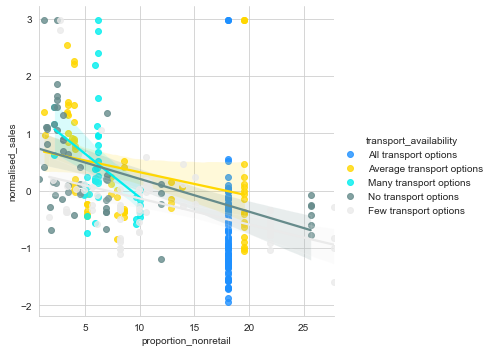

In [42]:
sns.lmplot(data= stores, x='proportion_nonretail', y= 'normalised_sales', hue= 'transport_availability')

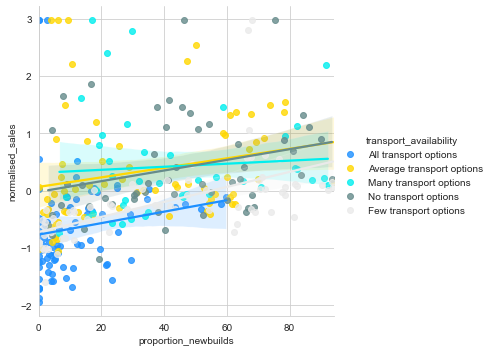

In [43]:
sns.lmplot(data= stores, x='proportion_newbuilds', y= 'normalised_sales', hue= 'transport_availability')

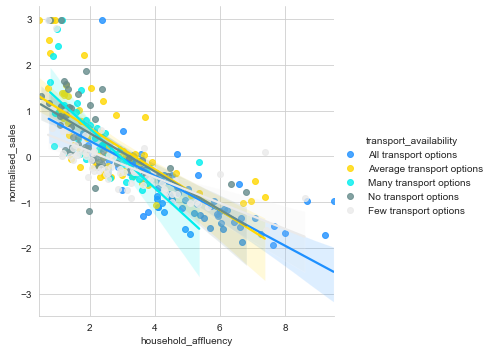

In [44]:
sns.lmplot(data= stores, x='household_affluency', y= 'normalised_sales', hue= 'transport_availability')

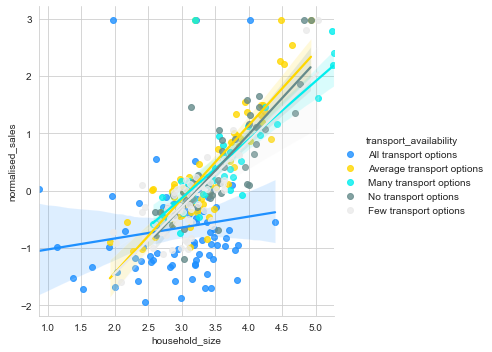

In [45]:
sns.lmplot(data= stores, x='household_size', y= 'normalised_sales', hue= 'transport_availability')

#### Observations from scatterplots and correlation matrix
-  Normalised sales trending down as household affluency goes up
-  Normalised sales trending up as household size goes up
-  When there are many transport options, normalised sales is trending up as the proportion of non retail commercial properties goes down
-  When there are few or no transport options, normalised sales is trending up as proportion of new buils goes up
-  With average transport options and increasing household size, normallised sales seems to be trending up.
-  With decreasing household affluency and many transport options, normalised sales is trending up.

<b>Concerns about the data:<br>
-  We can see that the commercial_property feature is missing about 10% of the data and school_proximity is missing about 20%.<br>
-  The balance for several variables.<br><br>

<b>Other useful information to collect:
-  What is the literacy level and educational level of the populations?<br>
-  What languages do they speak and what is the religious structure?<br>
-  Is the health Index weakening?<br>

## Q2

Build a model that can predict store sales based on the provided area features.<br>
Please show how you developed the model and report how well your model is performing.<br>
Constraint: Please use Random Forest as the model family to solve this problem.

-  <b>I will be using Distributed Random forest (h2o.ai)

In [46]:
# Import libraries
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()
#h2o.init(ip="localhost", port=54321)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM AdoptOpenJDK (build 11.0.5+10, mixed mode)
  Starting server from C:\Users\kci_2\Anaconda3\envs\ds_assessments\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kci_2\AppData\Local\Temp\tmpicgyxnw1
  JVM stdout: C:\Users\kci_2\AppData\Local\Temp\tmpicgyxnw1\h2o_kci_2_started_from_python.out
  JVM stderr: C:\Users\kci_2\AppData\Local\Temp\tmpicgyxnw1\h2o_kci_2_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Europe/London
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.0.6
H2O_cluster_version_age:    11 days
H2O_cluster_name:           H2O_from_python_kci_2_1qm1zh
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.930 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.3 final
--------------------------  ---------------------------------------------------------

In [47]:
train = stores 
given_test = stores_test
print(train.shape)
#print(given_test.shape)
print(train.columns)
#print(given_test.columns)

(320, 16)
Index(['location_id', 'crime_rate', 'proportion_flats', 'proportion_nonretail',
       'new_store', 'commercial_property', 'household_size',
       'proportion_newbuilds', 'public_transport_dist',
       'transport_availability', 'property_value', 'school_proximity',
       'competitor_density', 'household_affluency', 'normalised_sales',
       'county'],
      dtype='object')


In [48]:
# Convert data into h2o Frame
train = h2o.H2OFrame(train)
given_test = h2o.H2OFrame(given_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [49]:
train.head()

location_id crime_rate proportion_flats proportion_nonretail new_store commercial_property household_size proportion_newbuilds public_transport_dist transport_availability property_value school_proximity competitor_density household_affluency normalised_sales county 
 
 
 464 17.6005 0 18.1 no nan 2.926 29 2.9084 All transport options 666 20.2 368.74 4.5325 -0.399933 c_40 
 504 0.603556 20 3.97 no 14.85 4.52 10.6 2.1398 Average transport options 264 13 388.37 1.815 2.21631 c_80 
 295 0.60681 0 6.2 no 7.7 2.981 31.9 3.6715 Many transport options 307 17.4 378.35 2.9125 0.16692 c_53 
 187 0.0123848 55 2.25 no 1.95 3.453 68.1 7.3073 No transport options 300 15.3 394.72 2.0575 -0.0838035 c_65 
 193 0.0161816 100 1.32 no 3.05 3.816 59.5 8.3248 Average transport options 256 15.1 392.9 0.9875 0.962693 c_97 
 160 0.0686588 0 11.93 no 11.15 3.976 9 2.1675 No transport options 273 21 396.9 1.41 0.123316 c_69 
 43 0.254126 12.5 7.87 no 8.7 3.377 5.7 6.3467 Average transport options 311 15.2 392.52 5.1125 -0.846874 c_22 
 278 6.58113 0 18.1 no 9.1 3.242 35.3 3.4242 All transport options 666 20.2 396.9 2.685 0.0252065 c_54 
 387 17.9221 0 18.1 no 16.45 2.896 4.6 1.9096 All transport options 666 20.2 7.68 6.0975 -1.57724 c_51 
 98 5.43771 0 18.1 no 18.15 3.701 10 2.5975 All transport options 666 20.2 255.23 4.105 -0.69426 c_47

In [50]:
train["new_store"] = train["new_store"].asfactor()
train["transport_availability"] = train["transport_availability"].asfactor()
train["county"] = train["county"].asfactor()
given_test["new_store"] = given_test["new_store"].asfactor()
given_test["transport_availability"] = given_test["transport_availability"].asfactor()
given_test["county"] = given_test["county"].asfactor()

In [51]:
# Split the train dataset
train, valid, test = train.split_frame(ratios=[0.8, 0.15], seed=42)

In [52]:
# Seperate the target data and store it into y variable
y = 'normalised_sales'

# remove target and Id column from the dataset and store rest of the columns in X variable
X = list(train.columns)
X.remove(y)
X

['location_id',
 'crime_rate',
 'proportion_flats',
 'proportion_nonretail',
 'new_store',
 'commercial_property',
 'household_size',
 'proportion_newbuilds',
 'public_transport_dist',
 'transport_availability',
 'property_value',
 'school_proximity',
 'competitor_density',
 'household_affluency',
 'county']

In [53]:
##Random Forest Algorithm
# Prepare the hyperparameters
nfolds = 5
rf_params = {'max_depth': [3, 4, 5, 6, 7],
             'sample_rate': [0.8, 1.0],               # Row sample rate
             'mtries' : [3, 5, 4]
            }

In [54]:
# Search criteria for parameter space
search_criteria = {'strategy': "RandomDiscrete",
                   'seed': 1,
                   'stopping_metric': "AUTO",
                   'stopping_tolerance': 0.0005
                   }

In [55]:
# Prepare the grid object
rf_grid = H2OGridSearch(model=H2ORandomForestEstimator,      # Model to be trained
                        grid_id='rf_grid',                   # Grid Search ID
                        hyper_params=rf_params,              # Dictionary of parameters
                        search_criteria=search_criteria,       # RandomDiscrete
                        )

In [56]:
# Train the Model
start = time.time() 
rf_grid.train(x=X, y=y, 
              training_frame=train,
              validation_frame=valid,
              ntrees=500,      
              score_each_iteration=True,
              nfolds = nfolds,
              fold_assignment="Modulo",
              seed=1
             )

end = time.time()
(end - start)/60

drf Grid Build progress: |████████████████████████████████████████████████| 100%


4.177538824081421

In [57]:
# Find the Model performance 
rf_gridperf = rf_grid.get_grid(sort_by='RMSE', decreasing=False)
rf_gridperf

     max_depth mtries sample_rate         model_ids                 rmse
0            7      3         1.0  rf_grid_model_27   0.4874339193020232
1            7      3         0.8  rf_grid_model_12  0.49273147078848684
2            6      3         1.0   rf_grid_model_9  0.49452979122475266
3            7      4         1.0   rf_grid_model_6  0.49687842577155517
4            6      3         0.8  rf_grid_model_25  0.49878702295286426
5            7      4         0.8  rf_grid_model_17   0.5026517866590104
6            6      4         1.0  rf_grid_model_26   0.5026828093112347
7            6      4         0.8   rf_grid_model_2   0.5077964834109236
8            5      3         1.0   rf_grid_model_5   0.5080504501220002
9            5      3         0.8  rf_grid_model_14    0.509484996625413
10           7      5         1.0   rf_grid_model_3   0.5102143293849268
11           5      4         1.0  rf_grid_model_19   0.5127188827024847
12           6      5         1.0  rf_grid_model_18

In [58]:
# Identify the best model generated with least error
best_rf_model = rf_gridperf.models[0]
best_rf_model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_grid_model_27


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0             560166.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        7.0        7.0         7.0        42.0        94.0       71.504



ModelMetricsRegression: drf
** Reported on train data. **

MSE: NaN
RMSE: NaN
MAE: NaN
RMSLE: NaN
Mean Residual Deviance: NaN

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.2145083065605289
RMSE: 0.46315041461768003
MAE: 0.2998498460868157
RMSLE: NaN
Mean Residual Deviance: 0.2145083065605289

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.23759182568613124
RMSE: 0.4874339193020232
MAE: 0.31779372871574624
RMSLE: NaN
Mean Residual Deviance: 0.23759182568613124

Cross-Validation Metrics Summary: 


mean           sd  cv_1_valid  cv_2_valid  \
0                     mae  0.31804854   0.04930944  0.35542202  0.26355085   
1  mean_residual_deviance   0.2377654  0.079278626  0.32328433  0.13124037   
2                     mse   0.2377654  0.079278626  0.32328433  0.13124037   
3                      r2   0.7517561  0.065635376    0.707949   0.8001495   
4       residual_deviance   0.2377654  0.079278626  0.32328433  0.13124037   
5                    rmse  0.48159724   0.08536313    0.568581  0.36227113   
6                   rmsle         NaN          0.0         NaN         NaN   

   cv_3_valid  cv_4_valid  cv_5_valid  
0  0.29860747    0.289896  0.38276628  
1  0.27242675  0.18002267  0.28185284  
2  0.27242675  0.18002267  0.28185284  
3   0.6605857  0.81638575  0.77371025  
4  0.27242675  0.18002267  0.28185284  
5   0.5219452   0.4242908  0.53089815  
6         NaN         NaN         NaN


Scoring History: 


timestamp           duration  number_of_trees  training_rmse  \
0     2020-07-12 11:05:09   3 min 40.965 sec              0.0            NaN   
1     2020-07-12 11:05:09   3 min 40.967 sec              1.0            NaN   
2     2020-07-12 11:05:09   3 min 40.969 sec              2.0            NaN   
3     2020-07-12 11:05:09   3 min 40.971 sec              3.0            NaN   
4     2020-07-12 11:05:09   3 min 40.972 sec              4.0            NaN   
5     2020-07-12 11:05:09   3 min 40.974 sec              5.0            NaN   
6     2020-07-12 11:05:09   3 min 40.976 sec              6.0            NaN   
7     2020-07-12 11:05:09   3 min 40.978 sec              7.0            NaN   
8     2020-07-12 11:05:09   3 min 40.980 sec              8.0            NaN   
9     2020-07-12 11:05:09   3 min 40.982 sec              9.0            NaN   
10    2020-07-12 11:05:09   3 min 40.983 sec             10.0            NaN   
11    2020-07-12 11:05:09   3 min 40.985 sec             11.0            NaN   
12    2020-07-12 11:05:09   3 min 40.987 sec             12.0            NaN   
13    2020-07-12 11:05:09   3 min 40.989 sec             13.0            NaN   
14    2020-07-12 11:05:09   3 min 40.991 sec             14.0            NaN   
15    2020-07-12 11:05:09   3 min 40.993 sec             15.0            NaN   
16    2020-07-12 11:05:09   3 min 40.994 sec             16.0            NaN   
17    2020-07-12 11:05:09   3 min 40.996 sec             17.0            NaN   
18    2020-07-12 11:05:09   3 min 40.998 sec             18.0            NaN   
19    2020-07-12 11:05:09   3 min 41.001 sec             19.0            NaN   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1            NaN                NaN         0.468451        0.322554   
2            NaN                NaN         0.421188        0.289087   
3            NaN                NaN         0.509045        0.350132   
4            NaN                NaN         0.513322        0.333115   
5            NaN                NaN         0.514245        0.331213   
6            NaN                NaN         0.548291        0.339962   
7            NaN                NaN         0.518537        0.327042   
8            NaN                NaN         0.486404        0.311690   
9            NaN                NaN         0.477037        0.310101   
10           NaN                NaN         0.459334        0.307359   
11           NaN                NaN         0.440034        0.296562   
12           NaN                NaN         0.443621        0.299398   
13           NaN                NaN         0.450641        0.298956   
14           NaN                NaN         0.456972        0.298069   
15           NaN                NaN         0.447644        0.296071   
16           NaN                NaN         0.445623        0.290648   
17           NaN                NaN         0.445450        0.288303   
18           NaN                NaN         0.454686        0.295245   
19           NaN                NaN         0.452923        0.290076   

    validation_deviance  
0                   NaN  
1              0.219447  
2              0.177399  
3              0.259127  
4              0.263500  
5              0.264448  
6              0.300623  
7              0.268880  
8              0.236589  
9              0.227564  
10             0.210987  
11             0.193630  
12             0.196800  
13             0.203077  
14             0.208824  
15             0.200386  
16             0.198580  
17             0.198426  
18             0.206739  
19             0.205139


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0                   county         31823.949219           1.000000    0.271425
1      household_affluency         26640.851562           0.837132    0.227218
2           household_size         18569.113281           0.583495    0.158375
3               crime_rate          7263.827637           0.228250    0.061953
4     proportion_nonretail          6949.595703           0.218376    0.059273
5           property_value          5328.951660           0.167451    0.045450
6         school_proximity          4387.897461           0.137880    0.037424
7    public_transport_dist          4065.682617           0.127755    0.034676
8      commercial_property          3695.167725           0.116113    0.031516
9     proportion_newbuilds          3427.254395           0.107694    0.029231
10        proportion_flats          1394.930054           0.043833    0.011897
11  transport_availability          1358.562500           0.042690    0.011587
12      competitor_density          1150.025635           0.036137    0.009809
13             location_id           936.081909           0.029414    0.007984
14               new_store           255.884262           0.008041    0.002182

In [59]:
## Model Performances
best_rf_perf = best_rf_model.model_performance(test)   # Random Forest Model

In [60]:
### Retreive test set AUC
print(best_rf_perf.gini)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.91246647832353
RMSE: 0.955231112518604
MAE: 0.3731518210549416
RMSLE: 0.5676222234717876
Mean Residual Deviance: 0.91246647832353
<bound method MetricsBase.gini of >


In [61]:
plot_rf_pred = best_rf_model.predict(test).as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


In [62]:
test_df = test.as_data_frame()
test_df['predicted_normalised_sales'] = plot_rf_pred['predict']
#test_df.head()

#### Actual and predicted values

In [63]:
fig = px.scatter(test_df, x="location_id", y=["normalised_sales", "predicted_normalised_sales"])
fig.show()

#### Feature importance

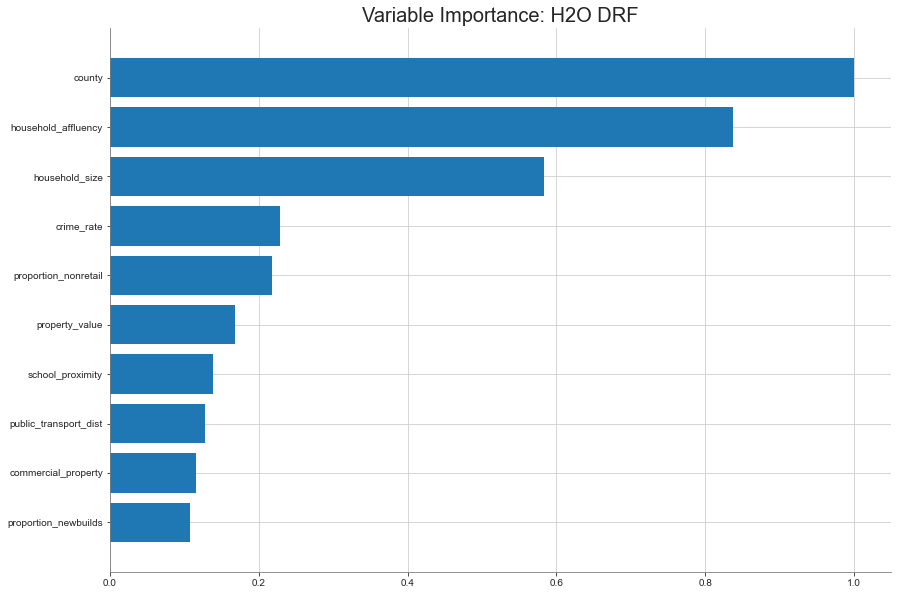

In [64]:
best_rf_model.varimp_plot()

#### Fit final model

In [ ]:
# Train on 100%

## Q3

Predict the sales value in the test dataset areas.<br> 
Make recommendations to stores team.<br>
Share your findings with product owners and other non-technical decision makers in the team.<br>
Improve the current results.

In [65]:
## Prediction of Model
rf_pred = best_rf_model.predict(given_test).as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


In [66]:
## Submission to Tesco
sub = stores_test
sub['predicted_normalised_sales'] = list(rf_pred['predict'])
sub.head()

location_id  crime_rate  proportion_flats  proportion_nonretail new_store  \
0          105    0.039968              34.0                  6.09        no   
1          400    0.587758              20.0                  3.97        no   
2          338    1.116926               0.0                  8.14        no   
3          227    1.517409               0.0                 19.58        no   
4          114   83.093533               0.0                 18.10        no   

   commercial_property  household_size  proportion_newbuilds  \
0                 4.15           3.590                  59.6   
1                14.85           5.398                   8.5   
2                 9.40           2.813                   0.0   
3                12.75           3.066                   0.0   
4                16.45           2.957                   0.0   

   public_transport_dist     transport_availability  property_value  \
0                 5.4917     Many transport options             329   
1                 2.2885  Average transport options             264   
2                 4.0952      Few transport options             307   
3                 1.7573  Average transport options             403   
4                 1.8026      All transport options             666   

   school_proximity  competitor_density  household_affluency county  \
0              16.1              395.75               2.3750   c_42   
1              13.0              386.86               1.4775  c_140   
2               NaN              394.54               4.9700   c_55   
3              14.7              353.89               1.6075   c_62   
4              20.2               16.45               5.1550   c_22   

   predicted_normalised_sales  
0                    0.262950  
1                    1.289175  
2                   -0.591701  
3                   -0.029358  
4                   -1.363170

In [186]:
sub.to_csv('stores_predicted.csv', index=False)

#### Predictions are shared on Data Studio
https://datastudio.google.com/reporting/18f606f0-8d23-41b7-845c-dab3ae5bfc83

#### Recomendations to Store Team and improvements
-  The mean absolute error for the model is -0.271, the predictions that are in excess of +/- 0.3 should be ok.
-  Improvement: Use a regressor that does not need to encode categorical variables
-  Improvement: Use randomized search to find better parameters for the model.
-  Try predicting the missing values from commercial property and school proximity instead of median

## Q4

Train model on masked data and predict target y.<br>
Explain steps.<br>
Provide comments to business assuming model would be used to make decisions involving important sums of money.

#### Take a look at the dataset and get summary statistics

In [154]:
# Load data
masked = pd.read_csv('../masked_dataset/train.csv')

In [155]:
#masked.head()
masked.describe()

x1          x2           y
count  100.000000  100.000000  100.000000
mean     0.444403    0.523374    0.554952
std      0.288595    0.291111    0.421430
min      0.000457    0.012779   -0.191714
25%      0.222642    0.265002    0.222144
50%      0.401859    0.527564    0.519598
75%      0.682649    0.784647    0.879761
max      0.996337    0.949549    1.499445

In [156]:
value_count(masked, 'NA')

{'x1': [0, '0.00%'], 'x2': [0, '0.00%'], 'y': [0, '0.00%']}

#### Look at the distribution of the target variable y

In [157]:
fig = px.box(masked, y="y", points='all')
fig.show()

In [158]:
hist_data = [masked['y']]
group_labels = ['y']
fig = ff.create_distplot(hist_data, group_labels)
fig.show()
print('min: {} max: {} mean: {} std: {}'.format(min(masked['y']), max(masked['y']), masked['y'].mean(), masked['y'].std()))

min: -0.19171439093035053 max: 1.499444980797613 mean: 0.5549524001167554 std: 0.42142960505918864


-  Target is well distributed

#### Check outliers

In [159]:
outlier_ratio(masked.x1)

{'percentile_based_outlier': [2, '2.00%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [0, '0.00%']}

In [160]:
outlier_ratio(masked.x2)

{'percentile_based_outlier': [2, '2.00%'],
 'mad_based_outlier': [0, '0.00%'],
 'std_div': [0, '0.00%'],
 'outlier_vote': [0, '0.00%']}

#### Correlation

In [161]:
masked.corr()

x1        x2         y
x1  1.000000  0.061202  0.536305
x2  0.061202  1.000000  0.705965
y   0.536305  0.705965  1.000000

In [162]:
fig = px.scatter_matrix(masked)
fig.show()

-  We can see an upward trend for x1 and x2
-  Add columns to form potential additional features and evaluate with correlation

In [163]:
masked['sum_x1_x2'] = masked['x1'] + masked['x2']

In [164]:
masked.corr()

x1        x2         y  sum_x1_x2
x1         1.000000  0.061202  0.536305   0.725620
x2         0.061202  1.000000  0.705965   0.731215
y          0.536305  0.705965  1.000000   0.853210
sum_x1_x2  0.725620  0.731215  0.853210   1.000000

#### Check feature importance

In [165]:
X_1 = masked.drop(['y'], axis=1)
y_1 = masked['y'].copy()

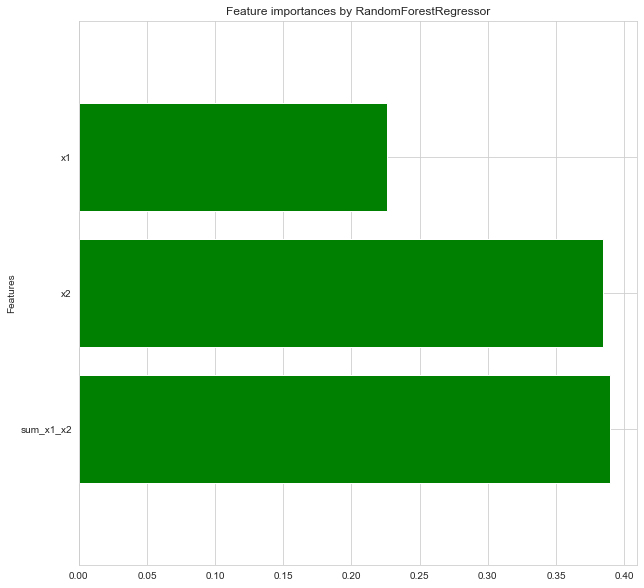

In [166]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(X_1, y_1)
feature_names = X_1.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:10]

plt.subplots(figsize=(10,10))
plt.title("Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.show()

-  From the plot above we can see that the new feature is prominent.

-  See if x2 can be used to cluster the points into different groups, if so, add as feature.

In [167]:
class cluster_target_encoder:
    def __init__(self,nclusters=4,seed=0):
        self.seed= seed
        self.nclusters= nclusters
    def make_encoding(self,df):
        self.encoding = df.groupby('X')['y'].mean()
    def fit(self,X,y):
        df = pd.DataFrame(columns=['X','y'],index=X.index)
        df['X'] = X
        df['y'] = y
        self.make_encoding(df)
        clust = KMeans(self.nclusters,random_state=self.seed)
        labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
        df['labels'] = labels
        self.clust_encoding = df.groupby('X')['labels'].median()
    def transform(self,X):
        res = X.map(self.clust_encoding).astype(float)
        return res
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

Populating the interactive namespace from numpy and matplotlib


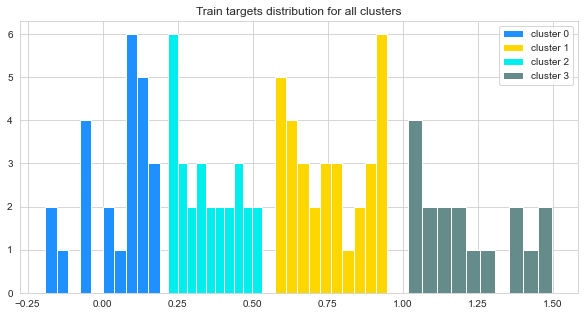

In [168]:
enc1 = cluster_target_encoder()
labels_train = enc1.fit_transform(X_1['x2'], y_1)
%pylab inline
plt.figure(figsize(10,5))
plt.hist(y_1.values[labels_train==0],bins=10,label='cluster 0')
plt.hist(y_1.values[labels_train==1],bins=10,label='cluster 1')
plt.hist(y_1.values[labels_train==2],bins=10,label='cluster 2')
plt.hist(y_1.values[labels_train==3],bins=10,label='cluster 3')
plt.legend()
plt.title('Train targets distribution for all clusters')
plt.show()

In [169]:
labels_train.head()

0    3.0
1    1.0
2    3.0
3    2.0
4    1.0
Name: x2, dtype: float64

In [170]:
X_1['labels']=labels_train
masked['labels'] = labels_train
#X_1.head()
masked.head()

x1        x2         y  sum_x1_x2  labels
0  0.784119  0.948352  1.437410   1.732472     3.0
1  0.911072  0.787079  0.943558   1.698150     1.0
2  0.549740  0.906819  1.197050   1.456559     3.0
3  0.036095  0.791149  0.408959   0.827244     2.0
4  0.581530  0.609205  0.836620   1.190736     1.0

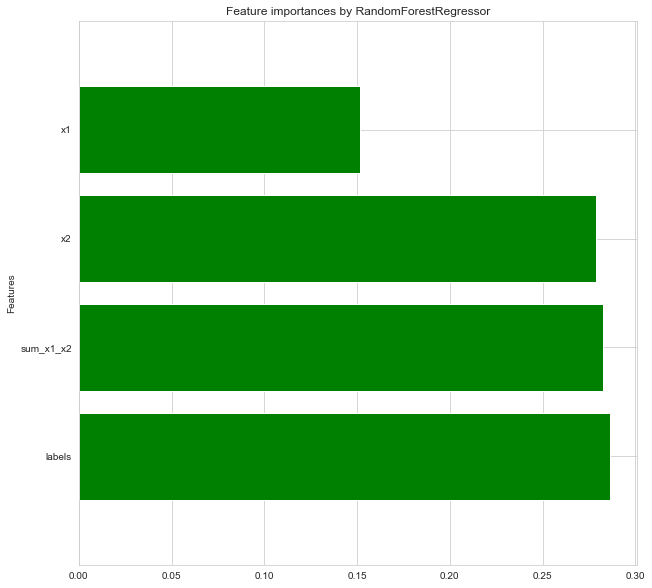

In [171]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(X_1, y_1)
feature_names = X_1.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:10]

plt.subplots(figsize=(10,10))
plt.title("Feature importances by RandomForestRegressor")
plt.ylabel("Features")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.show()

#### h2o models

In [172]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [173]:
#train_masked = masked
train_masked = masked
print(train_masked.shape)
print(train_masked.columns)

(100, 5)
Index(['x1', 'x2', 'y', 'sum_x1_x2', 'labels'], dtype='object')


In [174]:
## Convert data into h2o Frame
train_masked = h2o.H2OFrame(train_masked)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [175]:
# Split the train dataset
train_masked, valid, test = train_masked.split_frame(ratios=[0.7, 0.15], seed=42)

In [176]:
# Seperate the target data and store it into y variable
y = 'y'

# remove target column from the dataset and store rest of the columns in X variable
X = list(train_masked.columns)
X.remove(y)
X

['x1', 'x2', 'sum_x1_x2', 'labels']

In [177]:
## models
#We will now perform training of the models using below H2o supervised algorithms

#Gradient Boosting Machine (RF)

#Deep Learning (DL)

### 1. Gradient Boosting Machine (GBM)

# Prepare the hyperparameters
gbm_params = {'learn_rate': [0.01, 0.1], 
              'max_depth': [4, 5, 7],
              'sample_rate': [0.6, 0.8],               # Row sample rate
              'col_sample_rate': [0.2, 0.5, 0.9]       # Column sample rate per split (from 0.0 to 1.0)
             }

# Prepare the grid object
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator,   # Model to be trained
                          grid_id='gbm_grid1',                  # Grid Search ID
                          hyper_params=gbm_params,              # Dictionary of parameters
                          search_criteria={"strategy": "Cartesian"}   # RandomDiscrete
                          )

# Train the Model
start = time.time() 
gbm_grid.train(x=X,y=y, 
               training_frame=train_masked,
               validation_frame=valid,
               ntrees=100,      # Specify other GBM parameters not in grid
               score_tree_interval=5,     # For early stopping
               stopping_rounds=3,         # For early stopping
               stopping_tolerance=0.0005,
               seed=1)

end = time.time()
(end - start)/60

# Find the Model grid performance 
gbm_gridperf = gbm_grid.get_grid(sort_by='RMSE',decreasing = False)
gbm_gridperf

# Identify the best model generated with least error
best_gbm_model = gbm_gridperf.models[0]
best_gbm_model

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_grid1_model_66


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                      50.0               5808.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        2.0        5.0         3.4         4.0         6.0         4.58



ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.007235322624031818
RMSE: 0.08506069964461742
MAE: 0.06563316244218084
RMSLE: 0.06025397995615285
Mean Residual Deviance: 0.007235322624031818

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.011551112998150702
RMSE: 0.10747610431231075
MAE: 0.08375537962884978
RMSLE: 0.06142410513940332
Mean Residual Deviance: 0.011551112998150702

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-07-12 12:12:49   2.127 sec              0.0       0.426419   
1     2020-07-12 12:12:49   2.130 sec              5.0       0.278433   
2     2020-07-12 12:12:49   2.133 sec             10.0       0.186104   
3     2020-07-12 12:12:49   2.137 sec             15.0       0.142484   
4     2020-07-12 12:12:49   2.139 sec             20.0       0.116889   
5     2020-07-12 12:12:49   2.143 sec             25.0       0.105100   
6     2020-07-12 12:12:49   2.146 sec             30.0       0.096870   
7     2020-07-12 12:12:49   2.149 sec             35.0       0.093279   
8     2020-07-12 12:12:49   2.152 sec             40.0       0.089553   
9     2020-07-12 12:12:49   2.155 sec             45.0       0.087028   
10    2020-07-12 12:12:49   2.158 sec             50.0       0.085061   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0       0.357653           0.181833         0.381737        0.335222   
1       0.229611           0.077525         0.226732        0.207789   
2       0.146327           0.034635         0.138620        0.127437   
3       0.108177           0.020302         0.114260        0.103309   
4       0.086074           0.013663         0.102812        0.087552   
5       0.077978           0.011046         0.101794        0.080416   
6       0.073989           0.009384         0.101252        0.079392   
7       0.071621           0.008701         0.101804        0.079842   
8       0.069620           0.008020         0.105567        0.081810   
9       0.067549           0.007574         0.107515        0.083282   
10      0.065633           0.007235         0.107476        0.083755   

    validation_deviance  
0              0.145723  
1              0.051408  
2              0.019216  
3              0.013055  
4              0.010570  
5              0.010362  
6              0.010252  
7              0.010364  
8              0.011144  
9              0.011559  
10             0.011551


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0     labels            36.119972           1.000000    0.580586
1  sum_x1_x2            16.208639           0.448745    0.260535
2         x2             8.339244           0.230876    0.134044
3         x1             1.545058           0.042776    0.024835

In [178]:

### 2. Deep Learning

activation_opt = ["RectifierWithDropout", "TanhWithDropout"]

#L1 & L2 regularization
l1_opt = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]
l2_opt = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]

# Create the Hyperparameters
dl_params = {'activation': activation_opt,
             'input_dropout_ratio' : [0,0.05, 0.1],  # input layer dropout ratio to improve generalization. Suggested values are 0.1 or 0.2.
             'l1': l1_opt,
             'l2': l2_opt,
             'hidden_dropout_ratios':[[0.1,0.2,0.3], # hidden layer dropout ratio to improve generalization: one value per hidden layer.
                                      [0.1,0.5,0.5],
                                      [0.5,0.5,0.5]]
             }

search_criteria = {
                   'strategy': 'RandomDiscrete',
                   'max_runtime_secs': 1000,
                   'seed':1
                   }

# Prepare the grid object
dl_grid = H2OGridSearch(model=H2ODeepLearningEstimator(
                                                    epochs = 1000,   ## hopefully converges earlier...
                                                    adaptive_rate = True,  # http://cs231n.github.io/neural-networks-3/#sgd
                                                    stopping_metric="AUTO",
                                                    stopping_tolerance=1e-2,    ## stop when misclassification does not improve by >=1% for 2 scoring events
                                                    stopping_rounds=3,
                                                    hidden=[128,128,128],      ## more hidden layers -> more complex interactions
                                                    balance_classes= False,
                                                    standardize = True,  # If enabled, automatically standardize the data (mean 0, variance 1). If disabled, the user must provide properly scaled input data.
                                                    loss = "quantile"  # quantile for regression
                                                    ),
                        grid_id='dl_grid',
                        hyper_params=dl_params,
                        search_criteria=search_criteria)

# Train the Model
start = time.time() 
dl_grid.train(x=X,y=y, 
                training_frame=train_masked,
                validation_frame=valid,
                stopping_rounds=2,
                stopping_tolerance=0.0005,
                seed=1
                )

end = time.time()
(end - start)/60

# Find the Model performance 
dl_gridperf = dl_grid.get_grid(sort_by='RMSE',decreasing = False)
dl_gridperf

# Identify the best model generated with least error
best_dl_model = dl_gridperf.models[0]
best_dl_model


deeplearning Grid Build progress: |███████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  dl_grid_model_424


Status of Neuron Layers: predicting y, regression, quantile distribution, Quantile loss, 33,793 weights/biases, 404.9 KB, 72,000 training samples, mini-batch size 1


layer  units              type dropout l1    l2  mean_rate   rate_rms  \
0        1      4             Input       5                                  
1        2    128  RectifierDropout      10  0  0.01  0.0681332  0.0957685   
2        3    128  RectifierDropout      20  0  0.01   0.277814   0.239016   
3        4    128  RectifierDropout      30  0  0.01   0.206946   0.212541   
4        5      1            Linear          0  0.01   0.019524  0.0336794   

  momentum mean_weight weight_rms    mean_bias      bias_rms  
0                                                             
1        0  0.00995263  0.0694008    0.0138929     0.0864449  
2        0 -0.00581846  0.0403625  0.000946175     0.0673188  
3        0 -0.00664164  0.0349567    0.0568594     0.0953994  
4        0  -0.0159768    0.10366     0.028409  1.09713e-154



ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.022070805632426624
RMSE: 0.14856246373975704
MAE: 0.10888296391274535
RMSLE: 0.08712604647654895
Mean Residual Deviance: 0.054441481956372675

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.008811758919475051
RMSE: 0.09387096952452899
MAE: 0.07268577814221192
RMSLE: 0.05531218805289136
Mean Residual Deviance: 0.03634288907110596

Scoring History: 


timestamp           duration training_speed  epochs  \
0    2020-07-12 12:17:32          0.000 sec           None     0.0   
1    2020-07-12 12:17:32   4 min 17.584 sec  24000 obs/sec    10.0   
2    2020-07-12 12:17:33   4 min 18.941 sec  51985 obs/sec  1000.0   

   iterations  samples  training_rmse  training_deviance  training_mae  \
0           0      0.0            NaN                NaN           NaN   
1           1    720.0       0.198390           0.079988      0.159975   
2         100  72000.0       0.148562           0.054441      0.108883   

   training_r2  validation_rmse  validation_deviance  validation_mae  \
0          NaN              NaN                  NaN             NaN   
1     0.783546         0.196776             0.079480        0.158959   
2     0.878620         0.093871             0.036343        0.072686   

   validation_r2  
0            NaN  
1       0.734230  
2       0.939518


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0     labels             1.000000           1.000000    0.418816
1         x2             0.535798           0.535798    0.224401
2  sum_x1_x2             0.440319           0.440319    0.184413
3         x1             0.411567           0.411567    0.172371

In [179]:
## Compare Model Performances
best_gbm_perf= best_gbm_model.model_performance(test)  # GBM Model
best_dl_perf = best_dl_model.model_performance(test)   #deep Learning Model

In [180]:
### Retreive test set AUC
print(best_gbm_perf.gini)
print(best_dl_perf.gini)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.033517590850543705
RMSE: 0.18307810041221126
MAE: 0.14852140048612472
RMSLE: 0.1334620941084684
Mean Residual Deviance: 0.033517590850543705
<bound method MetricsBase.gini of >

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.028011492756342495
RMSE: 0.1673663429616077
MAE: 0.13450979722082346
RMSLE: 0.11626091499623038
Mean Residual Deviance: 0.06725489861041173
<bound method MetricsBase.gini of >


#### Actual and predicted values

In [181]:
plot_dl_pred = best_dl_model.predict(test).as_data_frame()

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [182]:
test_df_masked = test.as_data_frame()
test_df_masked['predicted_y'] = plot_dl_pred['predict']
#test_df.head()

In [183]:
fig = px.scatter(test_df_masked, y=["y", "predicted_y"])
fig.show()

In [184]:
## Submission to Tesco, save model
sub_masked = test_df_masked
sub_masked.head()

x1        x2         y  sum_x1_x2  labels  predicted_y
0  0.782397  0.170203  0.324574   0.952600       2     0.354640
1  0.271339  0.718940  0.761633   0.990280       1     0.667637
2  0.893020  0.407206  0.919854   1.300226       1     0.683234
3  0.502020  0.220342 -0.054607   0.722362       0     0.074748
4  0.341073  0.375284 -0.045038   0.716357       0     0.086356

In [185]:
sub_masked.to_csv('tesco_stores_predicted_masked.csv', index=False)

#### comments to business
-  The engineered feature 'labels' is the most important